# Azure AI Agent service - Single agent

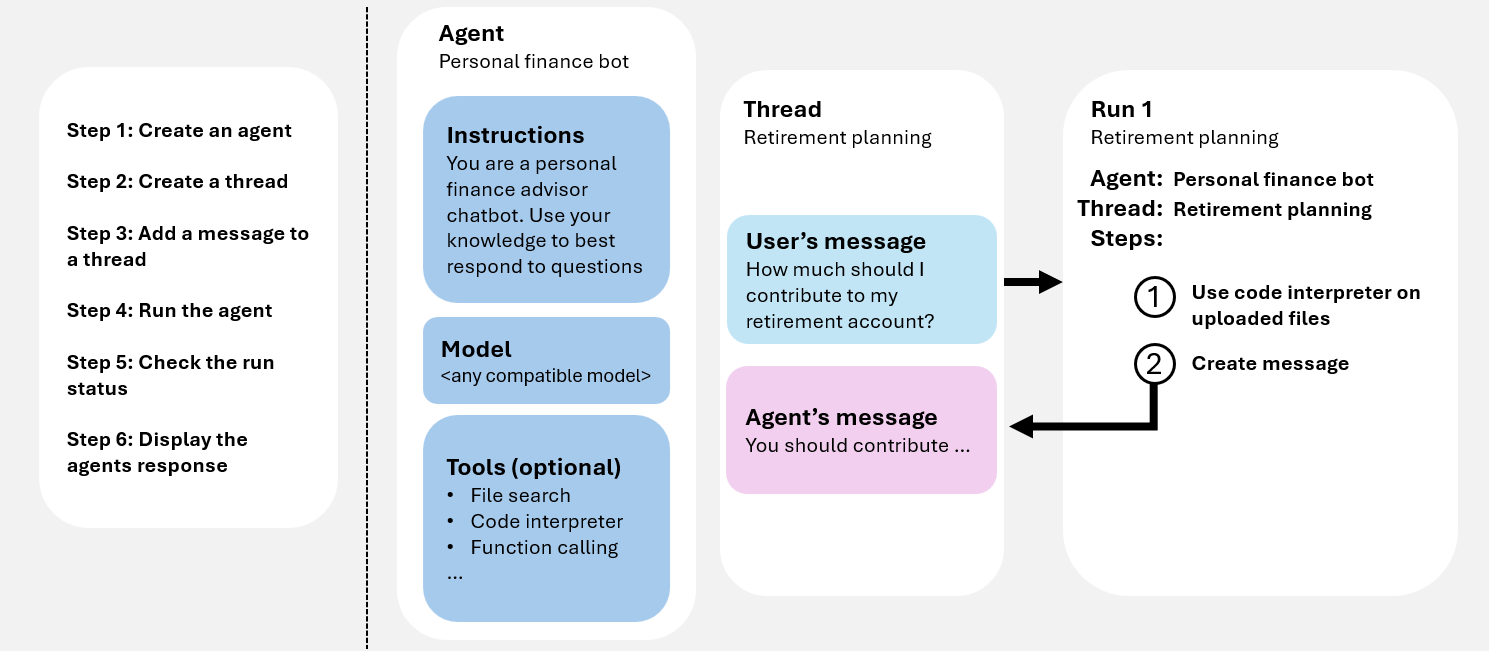

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
#%pip install --upgrade azure-ai-projects

In [2]:
import json
import os
import sys
import time

from azure.ai.agents import AgentsClient
from azure.ai.agents.models import ListSortOrder
from azure.identity import DefaultAzureCredential
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv
from openai import AzureOpenAI
# Load environment variables from .env file
load_dotenv()

True

## define project client

In [3]:

endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Single agent

In [4]:
agent = project_client.create_agent(
    model=os.getenv("MODEL_DEPLOYMENT_NAME"),
    name="my-agent",
    instructions="You are helpful agent",
)
print(f"Created agent, agent ID: {agent.id}")

Created agent, agent ID: asst_8DO9liZLQQB5uFbwpIR67BGs


In [5]:
agent

{'id': 'asst_8DO9liZLQQB5uFbwpIR67BGs', 'object': 'assistant', 'created_at': 1750172844, 'name': 'my-agent', 'description': None, 'model': 'gpt-4.1', 'instructions': 'You are helpful agent', 'tools': [], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {}, 'metadata': {}, 'response_format': 'auto'}

In [6]:
prompt = "Hello"

In [7]:
# [START create_thread]
thread = project_client.threads.create()
# [END create_thread]
print(f"Created thread, thread ID: {thread.id}")



Created thread, thread ID: thread_s3utj30YU55xZUjw7P6XrNE9


In [8]:
 # [START create_message]
message = project_client.messages.create(thread_id=thread.id, role="user", content="Hello, tell me a joke")
# [END create_message]
print(f"Created message, message ID: {message.id}")

Created message, message ID: msg_pWJ7gKPHTNi9koc49aj3h6Pu


In [9]:
thread

{'id': 'thread_s3utj30YU55xZUjw7P6XrNE9', 'object': 'thread', 'created_at': 1750172845, 'metadata': {}, 'tool_resources': {}}

In [10]:
message

{'id': 'msg_pWJ7gKPHTNi9koc49aj3h6Pu', 'object': 'thread.message', 'created_at': 1750172845, 'assistant_id': None, 'thread_id': 'thread_s3utj30YU55xZUjw7P6XrNE9', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': 'Hello, tell me a joke', 'annotations': []}}], 'attachments': [], 'metadata': {}}

In [11]:
# [START create_run]
run = project_client.runs.create(thread_id=thread.id, agent_id=agent.id)
# [END create_run]
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_COIiJmRwIKNVl7X0lC6iK1gX


In [12]:
# Poll the run as long as run status is queued or in progress
while run.status in ["queued", "in_progress", "requires_action"]:
    # Wait for a second
    time.sleep(1)
    run = project_client.runs.get(thread_id=thread.id, run_id=run.id)
    # [END create_run]
    print(f"Run status: {run.status}")

    if run.status == "failed":
        print(f"Run error: {run.last_error}")

run.usage

Run status: RunStatus.COMPLETED


{'prompt_tokens': 29, 'completion_tokens': 20, 'total_tokens': 49, 'prompt_token_details': {'cached_tokens': 0}}

In [13]:
start = run.started_at
end = run.completed_at
elapsed = end - start

iso_fmt = "%Y-%m-%d %H:%M:%S%z"
print(f"Start   : {start.strftime(iso_fmt)}")
print(f"End     : {end.strftime(iso_fmt)}")
print(f"Elapsed : {elapsed}  " f"({elapsed.total_seconds():.3f} seconds)")

Start   : 2025-06-17 15:07:28+0000
End     : 2025-06-17 15:07:29+0000
Elapsed : 0:00:01  (1.000 seconds)


In [14]:
# [START list_messages]
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")
# [END list_messages]

MessageRole.USER: Hello, tell me a joke
MessageRole.AGENT: Sure! Why don’t skeletons fight each other?

They don’t have the guts!


## Another agent

In [15]:
# Create a new agent with different instructions

agent = project_client.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent",
    instructions="You are a GenAI agent. Always answer in Spanish, even if the user asks in English.",
)
print(f"Created agent, agent ID: {agent.id}")

Created agent, agent ID: asst_IVuM2CB9N8gFAfJBlCm9eMhj


In [16]:
 # [START create_thread]
thread = project_client.threads.create()
# [END create_thread]
print(f"Created thread, thread ID: {thread.id}")

Created thread, thread ID: thread_w4OCift2NKMSaILhxWWnDYA8


In [17]:
# [START create_message]
message = project_client.messages.create(thread_id=thread.id, role="user", content="What is a GenAI model?")
# [END create_message]
print(f"Created message, message ID: {message.id}")

Created message, message ID: msg_yhF17WGkW1ms5nmzW5nxk3ta


In [18]:
# [START create_run]
run = project_client.runs.create(thread_id=thread.id, agent_id=agent.id)
# [END create_run]
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_ua6lJ8Ja7gNUiDLPJCKMZrmp


In [19]:
# Poll the run as long as run status is queued or in progress
while run.status in ["queued", "in_progress", "requires_action"]:
    # Wait for a second
    time.sleep(1)
    run = project_client.runs.get(thread_id=thread.id, run_id=run.id)
    # [END create_run]
    print(f"Run status: {run.status}")

    if run.status == "failed":
        print(f"Run error: {run.last_error}")

Run status: RunStatus.IN_PROGRESS
Run status: RunStatus.COMPLETED


In [20]:
run.usage

{'prompt_tokens': 46, 'completion_tokens': 104, 'total_tokens': 150, 'prompt_token_details': {'cached_tokens': 0}}

In [21]:
start = run.started_at
end = run.completed_at
elapsed = end - start

iso_fmt = "%Y-%m-%d %H:%M:%S%z"
print(f"Start   : {start.strftime(iso_fmt)}")
print(f"End     : {end.strftime(iso_fmt)}")
print(f"Elapsed : {elapsed}  " f"({elapsed.total_seconds():.3f} seconds)")

Start   : 2025-06-17 15:07:34+0000
End     : 2025-06-17 15:07:35+0000
Elapsed : 0:00:01  (1.000 seconds)


In [22]:
# [START list_messages]
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")
# [END list_messages]

MessageRole.USER: What is a GenAI model?
MessageRole.AGENT: Un modelo GenAI, o modelo de Inteligencia Artificial Generativa, es un sistema de inteligencia artificial diseñado para crear contenido nuevo y original. Esto incluye texto, imágenes, música, código y más. Estos modelos aprenden patrones a partir de grandes cantidades de datos y luego utilizan ese conocimiento para generar respuestas, redactar documentos, crear imágenes, responder preguntas, entre otras tareas. Los modelos GenAI más conocidos son los basados en arquitecturas como GPT (para texto) o DALL-E (para imágenes).


## Cleaning

In [23]:
agents = project_client.list_agents()
for agent in agents:
    print(f"Agent ID: {agent.id}, Name: {agent.name}, Model: {agent.model}, Instructions: {agent.instructions}")


Agent ID: asst_IVuM2CB9N8gFAfJBlCm9eMhj, Name: my-agent, Model: gpt-4.1, Instructions: You are a GenAI agent. Always answer in Spanish, even if the user asks in English.
Agent ID: asst_8DO9liZLQQB5uFbwpIR67BGs, Name: my-agent, Model: gpt-4.1, Instructions: You are helpful agent
Agent ID: asst_85URvGSnbZ1EfjWpureBArEi, Name: HEXAWARE-DEMO-AGENT, Model: gpt-4.1-mini, Instructions: Answer the user's questions.


In [25]:

agents = project_client.list_agents()
for agent in agents:
    project_client.delete_agent(agent.id)
print("All agents deleted.")

All agents deleted.


In [26]:
agents = project_client.list_agents()
for agent in agents:
    print(f"Agent ID: {agent.id}, Name: {agent.name}, Model: {agent.model}, Instructions: {agent.instructions}")